In [19]:
# !pip install tensorflow
# !pip install numpy
# !pip install pandas
# !pip install matplotlib


In [20]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

FileNotFoundError: [Errno 2] No such file or directory: 'hair_types\\Straight_Hair\\graphicstock-young-handsome-asiatic-long-brown-straight-hair-woman-taking-selfie-outdoor-in-the-city-with-a-smartphone-smiling-vanity-technology-social-network-concept_B6fyU2Ok-_SB_PM.jpg'

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 985 files belonging to 3 classes.
Using 887 files for training.
Found 985 files belonging to 3 classes.
Using 98 files for validation.


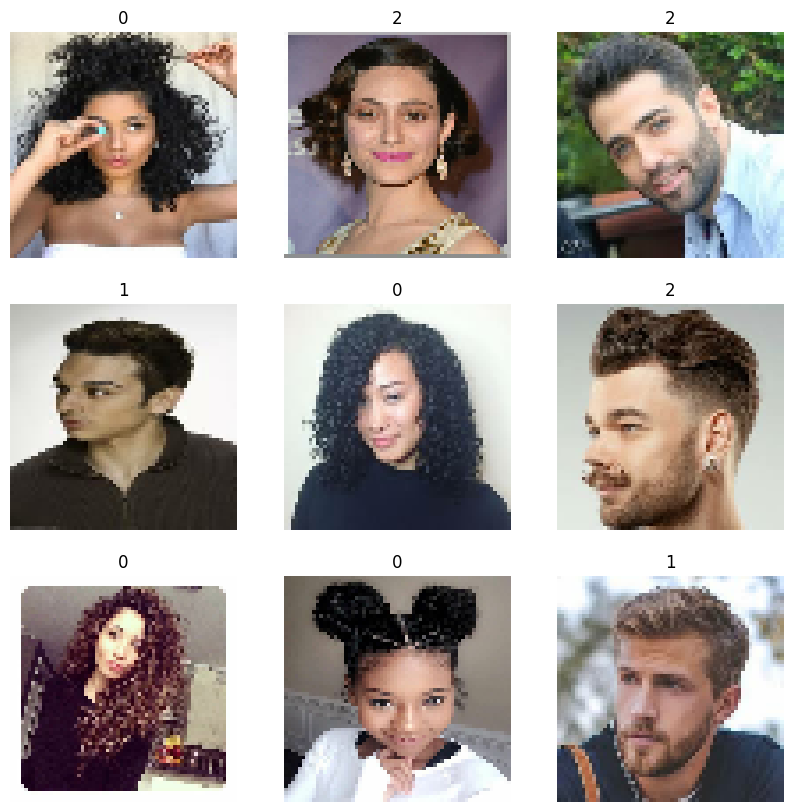

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt


model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))
model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.1))

model.add(layers.Conv2D(filters=128, kernel_size=7, strides=(1,1), padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-05), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SpatialDropout2D(0.1))
#model.add(Dropout(0.3))

model.add(layers.Conv2D(filters=192, kernel_size=5, strides=(1,1), padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-05), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.SpatialDropout2D(0.1))
#model.add(Dropout(0.3))

model.add(layers.Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='valid', dilation_rate=2, kernel_regularizer=keras.regularizers.l2(1e-05), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.SpatialDropout2D(0.1))
#model.add(Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(100, activation="relu"))
model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.Dropout(0.3))  # Uncommented and adjusted Dropout

model.add(layers.Dense(50, activation="relu"))
model.add(layers.BatchNormalization())  # Added Batch Normalization before activation
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.3))  # Uncommented and adjusted Dropout


model.add(layers.Dense(3, activation="softmax"))

#tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

epochs = 150

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)



Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.3491 - loss: 1.5673 - val_accuracy: 0.2653 - val_loss: 1.1051
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.3412 - loss: 1.5522 - val_accuracy: 0.2755 - val_loss: 1.1124
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.3461 - loss: 1.4474 - val_accuracy: 0.3367 - val_loss: 1.1036
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.3691 - loss: 1.4515 - val_accuracy: 0.2755 - val_loss: 1.1037
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.3746 - loss: 1.3858 - val_accuracy: 0.3265 - val_loss: 1.1026
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.3794 - loss: 1.4470 - val_accuracy: 0.3061 - val_loss: 1.1025
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.4068 - loss: 1.3779 - val_accuracy: 0.3673 - val_loss: 1.1002
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.3593 - loss: 1.4207 - val_acc

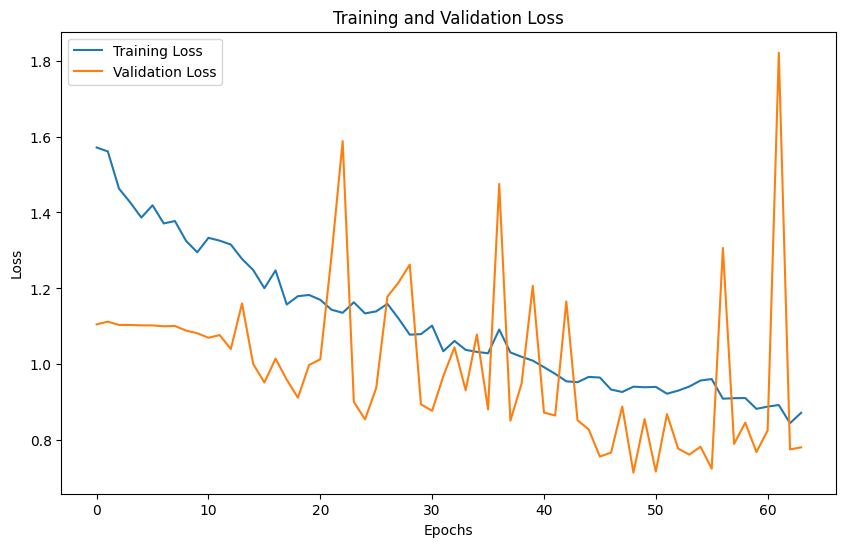

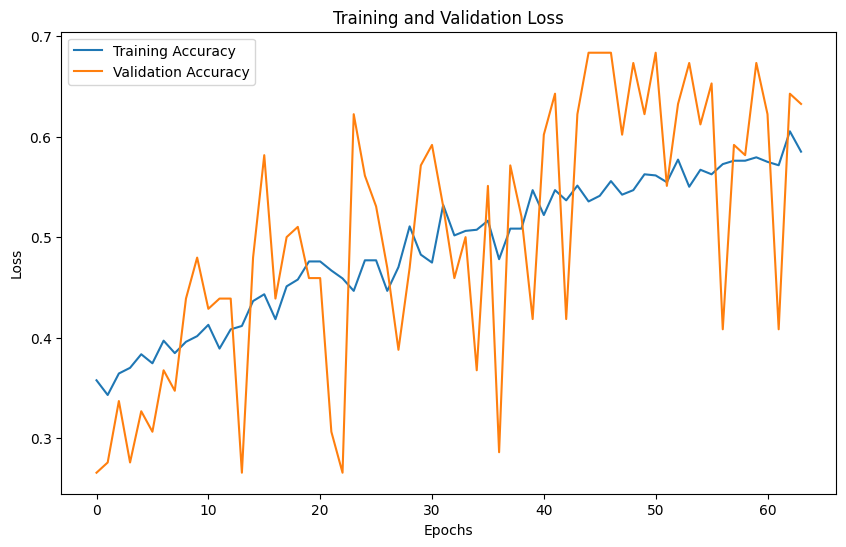

In [4]:
# Define the early stopping callback
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with early stopping
#model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

# Assuming train_ds and val_ds are defined and the model is compiled
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
This image is 0.99 percent curly hair, 0.01 percent straight hair, and 0.00 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
This image is 0.99 percent curly hair, 0.01 percent straight hair, and 0.00 percent wavy hair.
